## **Deep Learning Made Easy**

----

**Author**:  <a href="https://www.linkedin.com/in/valdivino-alexandre-de-santiago-j%C3%BAnior-103109206/?locale=en_US">Valdivino Alexandre de Santiago Júnior</a>

<br>

**Licence**: GNU GENERAL PUBLIC LICENSE, Version 3 (GPLv3)

<br>

This notebook is related to the handwritten digit classification problem based on the classical Modified National Institute of Standards and Technology (MNIST) database. Hovewer, its goal is to address performance bottlenecks of the network/model via the TensorBoard Plugin with PyTorch Profiler. Hence, it will not cover the classification task completely. It uses three neural networks: ```SNN500``` by <a href="https://github.com/AvivSham/Pytorch-MNIST-colab">Aviv Shamsian</a>, ```CNN3L``` by <a href="https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118">Nutan</a>, and ```LeNet-5``` by <a href="https://github.com/bollakarthikeya/LeNet-5-PyTorch/blob/master/lenet5_gpu.py">Bolla Karthikeya</a>. 




In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import time
import torch.profiler
import torch.utils.data

In [2]:
# This function obtains the number of trainable parameters of the 
# model/network.
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total trainable params: {total_params}")
    return total_params

In [3]:
# Just visualising some images
def visualise_images(img, lab, t):
   fig = plt.figure()
   for i in range(6):
     plt.subplot(2,3,i+1)
     plt.tight_layout()
     plt.imshow(img[i][0], cmap='gray', interpolation='none')
     plt.title("{} - class: {}".format(t,lab[i]))
     plt.xticks([])
     plt.yticks([])

## **Define important variables**
----

Here, we define the number of classes, some hyper-parameters, and the number of images of the training dataset to consider in the performance analysis.

In [4]:
num_classes = 10 # Number of output classes, discrete range [0,9]

# Hyper-parameters
batch_size = 100 # The size of input data took for one iteration
lr = 1e-3 # Learning rate

# Number of images: profiling
num_images = 10000 # Number of images to consider
max_batches = num_images/batch_size # Maximum number of batches
print('Maximum number of batches: ', int(max_batches))

Maximum number of batches:  100


## **MNIST dataset**
----

Downloading and handling the MNIST dataset. Note that, as the PyTorch documentation, <a href="https://pytorch.org/vision/stable/transforms.html">```transforms.ToTensor()```</a> "converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8".

In [5]:
# Downloading MNIST dataset. We only need the training dataset in this analysis.
train_data = dsets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

print('#'*20)
print('Training dataset: ', train_data)

####################
Training dataset:  Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
# Wrap an iterable around the dataset to enable easy access to the samples.
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                        batch_size = batch_size,
                                        shuffle = True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device is: ', device)

Device is:  cuda:0


## **Looking at the training dataset**

----

Just taking a quick look at the training dataset.



One batch - training dataset: torch.Size([100, 1, 28, 28])

Each image of the batch:
Image: 0 - Input shape: torch.Size([1, 28, 28]) - Class: 5
Image: 1 - Input shape: torch.Size([1, 28, 28]) - Class: 3
Image: 2 - Input shape: torch.Size([1, 28, 28]) - Class: 5
Image: 3 - Input shape: torch.Size([1, 28, 28]) - Class: 8
Image: 4 - Input shape: torch.Size([1, 28, 28]) - Class: 7
Image: 5 - Input shape: torch.Size([1, 28, 28]) - Class: 1
Image: 6 - Input shape: torch.Size([1, 28, 28]) - Class: 6
Image: 7 - Input shape: torch.Size([1, 28, 28]) - Class: 3
Image: 8 - Input shape: torch.Size([1, 28, 28]) - Class: 9
Image: 9 - Input shape: torch.Size([1, 28, 28]) - Class: 9
Image: 10 - Input shape: torch.Size([1, 28, 28]) - Class: 4
Image: 11 - Input shape: torch.Size([1, 28, 28]) - Class: 7
Image: 12 - Input shape: torch.Size([1, 28, 28]) - Class: 7
Image: 13 - Input shape: torch.Size([1, 28, 28]) - Class: 9
Image: 14 - Input shape: torch.Size([1, 28, 28]) - Class: 2
Image: 15 - Input shape: 

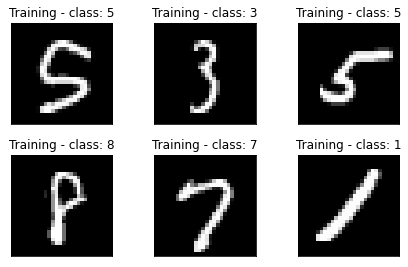

In [7]:
batch_train = enumerate(train_loader)
batch_idx, (batch_train_data, batch_train_classes) = next(batch_train)
print('One batch - training dataset:', batch_train_data.shape)

print('\nEach image of the batch:')
for i in range(batch_train_classes.shape[0]):
  print('Image: {} - Input shape: {} - Class: {}'.format(i, batch_train_data[i].shape, batch_train_classes[i]))
  if i == (batch_train_classes.shape[0]-1):
    print('The "image" itself: ', batch_train_data[i])

visualise_images(batch_train_data, batch_train_classes, 'Training')

## **Neural networks**

----

We use three neural networks in this analysis. The first is ```SNN500``` which is a shallow neural network (SNN) with a single hidden layer containing 500 neurons (traditionally, a model/network is considered shallow when it has one or two hidden layers). 

<img src="https://scipython.com/static/media/uploads/blog/shallow-neural-net/snn.png" width="300"/>

<br>

The second network is ```CNN3L``` which is also considered an SNN because it has two hidden (convolutional) layers and the output layer 

<br>

The third network is the classical <a href="https://ieeexplore.ieee.org/document/726791">```LeNet-5```</a> DNN with five layers where four are hidden ones.





In [8]:
class SNN500(nn.Module):
  def __init__(self, input_sz, hidden_sz, num_clas):
    super(SNN500,self).__init__()
    self.fc1 = nn.Linear(input_sz, hidden_sz)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_sz, num_clas)
  
  def forward(self,x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

In [9]:
class CNN3L(nn.Module):
    def __init__(self, num_clas):
        super(CNN3L, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),                
        )
        # Fully-connected layer
        self.out = nn.Linear(32 * 7 * 7, num_clas)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # Flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output   

In [10]:
class LeNet5(nn.Module):          
    def __init__(self, num_clas):     
        super(LeNet5, self).__init__()
        # Convolution 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2, bias=True)
        # Max-pooling
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2)
        # Convolution
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        # Max-pooling
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2) 
        # Fully-connected layers
        self.fc1 = nn.Linear(16*5*5, 120)   # convert matrix with 16*5*5 (= 400) features to a matrix of 120 features (columns)
        self.fc2 = nn.Linear(120, 84)       # convert matrix with 120 features to a matrix of 84 features (columns)
        self.fc3 = nn.Linear(84, num_clas)        # convert matrix with 84 features to a matrix of 10 features (columns)
        
    def forward(self, x):
        # Convolve, then perform ReLU non-linearity
        x = nn.functional.relu(self.conv1(x))  
        # Max-pooling with 2x2 grid 
        x = self.max_pool_1(x) 
        # Convolve, then perform ReLU non-linearity
        x = nn.functional.relu(self.conv2(x))
        # Max-pooling with 2x2 grid
        x = self.max_pool_2(x)
        # First flatten 'max_pool_2_out' to contain 16*5*5 columns
        x = x.view(-1, 16*5*5)
        # FC-1, then perform ReLU non-linearity
        x = nn.functional.relu(self.fc1(x))
        # FC-2, then perform ReLU non-linearity
        x = nn.functional.relu(self.fc2(x))
        # FC-3
        x = self.fc3(x)
        return x

## **Select the model**

----

Now, we can select one of the models/networks.

In [11]:
opt = input("Enter your choice:")
if opt =='1':
  input_size = 784 # img_size = (28,28) ---> 28*28=784 in total
  hidden_size_tb = 500 # Number of nodes at hidden layer
  net = SNN500(input_size, hidden_size_tb, num_classes)
  opt_name = 'SNN500'
  print("You selected SNN500!")
elif opt =='2':
  net = CNN3L(num_classes)
  opt_name = 'CNN3L'
  print("You selected CNN3L!")
elif opt =='3':
  net = LeNet5(num_classes)
  opt_name = 'LeNet-5'
  print("You selected LeNet-5!")
else:
  print("Invalid Option!")

if torch.cuda.is_available():
   net.to(device)

Enter your choice:1
You selected SNN500!


## **Define loss function and optimiser**

----

The <a href="https://github.com/AvivSham/Pytorch-MNIST-colab">CrossEntropyLoss</a> function combines LogSoftmax and NLLLoss in one single class. The learning rate has already been defined.

In [12]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

print('Checking trainable parameters: {}'.format(count_parameters(net)))

+------------+------------+
|  Modules   | Parameters |
+------------+------------+
| fc1.weight |   392000   |
|  fc1.bias  |    500     |
| fc2.weight |    5000    |
|  fc2.bias  |     10     |
+------------+------------+
Total trainable params: 397510
Checking trainable parameters: 397510


## **Training phase**

----

Here, we starting training the model (```net.train()``` and function ```train_model(data)```).

In [13]:
net.train() 
def train_model(data):
  if opt == '1':
    images, labels = Variable(data[0].view(-1,28*28)).to(device), Variable(data[1]).to(device)
  elif (opt == '2') or (opt == '3'):
    images, labels = Variable(data[0]).to(device), Variable(data[1]).to(device) 
      
  optimizer.zero_grad()
  with torch.set_grad_enabled(True):
    outputs = net(images)
    _, preds = torch.max(outputs, 1)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()


## **Use the PyTorch Profiler**
----

Here, we use the PyTorch Profiler to record execution events. After running this notebook, the results will be saved under ```./log/xyz``` folder.

In [14]:
with torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/mnist_'+opt_name+'_bat_'+str(batch_size)),
        record_shapes=True,
        with_stack=True
) as prof:
    for num_batch, batch_data in enumerate(train_loader):
        print('Batch number:', num_batch)
        if num_batch >= int(max_batches): 
            break
        train_model(batch_data)
        prof.step()  # Need to call this at the end of each step to notify profiler of steps' boundary.

Batch number: 0
Batch number: 1
Batch number: 2
Batch number: 3
Batch number: 4
Batch number: 5
Batch number: 6
Batch number: 7
Batch number: 8
Batch number: 9
Batch number: 10
Batch number: 11
Batch number: 12
Batch number: 13
Batch number: 14
Batch number: 15
Batch number: 16
Batch number: 17
Batch number: 18
Batch number: 19
Batch number: 20
Batch number: 21
Batch number: 22
Batch number: 23
Batch number: 24
Batch number: 25
Batch number: 26
Batch number: 27
Batch number: 28
Batch number: 29
Batch number: 30
Batch number: 31
Batch number: 32
Batch number: 33
Batch number: 34
Batch number: 35
Batch number: 36
Batch number: 37
Batch number: 38
Batch number: 39
Batch number: 40
Batch number: 41
Batch number: 42
Batch number: 43
Batch number: 44
Batch number: 45
Batch number: 46
Batch number: 47
Batch number: 48
Batch number: 49
Batch number: 50
Batch number: 51
Batch number: 52
Batch number: 53
Batch number: 54
Batch number: 55
Batch number: 56
Batch number: 57
Batch number: 58
Batch n

## **Run TensorBoard**
----

In order to visualise the results and check the performance bottlenecks of the model, proceed as follows as per the <a href="https://pytorch.org/tutorials/intermediate/tensorboard_profiler_tutorial.html">PyTorch tutorial </a>:



1. download the results in ```./log/xyz``` to your computer; 
2. install PyTorch Profiler TensorBoard Plugin (```pip install torch_tb_profiler```);
3. launch the TensorBoard (```tensorboard --logdir=./log```);
4. open the TensorBoard profile URL in Google Chrome browser (```http://localhost:6006/#pytorch_profiler```). 



